# Порівняння різних моделей нейронних мереж на наборі даних CIFAR-10

## Імпорт необхідних бібліотек і функцій

In [2]:
%pip install torch torchvision matplotlib pandas


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Імпорт необхідних бібліотек
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt
import pandas as pd
import tracemalloc
import ssl
import urllib.request

# Вимкнення перевірки SSL-сертифікатів
ssl._create_default_https_context = ssl._create_unverified_context

from models.resnet import get_resnet_model
from models.vgg import get_vgg_model
from models.densenet import get_densenet_model


# 2:  Підготовка даних CIFAR-10 з масштабуванням та зменшенням кількості

In [4]:
# Перетворення даних для нормалізації та масштабування (CIFAR-10)
transform_cifar10 = transforms.Compose(
    [transforms.Resize((32, 32)),  # Масштабування зображень до 128x128
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

# Завантаження навчальних даних CIFAR-10 (використовуємо лише частину даних для швидшого тренування)
trainset_cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                download=True, transform=transform_cifar10)
subset_train_cifar10 = torch.utils.data.Subset(trainset_cifar10, range(0, 3000))  # Використовуємо лише 2,000 зразків
trainloader_cifar10 = torch.utils.data.DataLoader(subset_train_cifar10, batch_size=64,  # Менший розмір міні-пакету
                                                  shuffle=True, num_workers=4)  # Збільшення кількості робітників

# Завантаження тестових даних CIFAR-10
testset_cifar10 = torchvision.datasets.CIFAR10(root='./data', train=False,
                                               download=True, transform=transform_cifar10)
testloader_cifar10 = torch.utils.data.DataLoader(testset_cifar10, batch_size=64,  # Менший розмір міні-пакету
                                                 shuffle=False, num_workers=4)  # Збільшення кількості робітників

classes_cifar10 = ('plane', 'car', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


# 3: Підготовка даних MNIST з зменшенням кількості

In [5]:
# Перетворення даних для нормалізації та перетворення в тензори (MNIST)
transform_mnist = transforms.Compose([
    transforms.Resize((224, 224)),  # Збільшення розміру зображень до 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Завантаження навчальних даних MNIST (використовуємо лише частину даних для швидшого тренування)
trainset_mnist = torchvision.datasets.MNIST(root='./data', train=True,
                                            download=True, transform=transform_mnist)
subset_train_mnist = torch.utils.data.Subset(trainset_mnist, range(0, 3000))  # Використовуємо лише 2,000 зразків
trainloader_mnist = torch.utils.data.DataLoader(subset_train_mnist, batch_size=100,  # Розмір міні-пакету 100
                                                shuffle=True, num_workers=4)  # Збільшення кількості робітників

# Завантаження тестових даних MNIST
testset_mnist = torchvision.datasets.MNIST(root='./data', train=False,
                                           download=True, transform=transform_mnist)
testloader_mnist = torch.utils.data.DataLoader(testset_mnist, batch_size=100,  # Розмір міні-пакету 100
                                               shuffle=False, num_workers=4)  # Збільшення кількості робітників

classes_mnist = [str(i) for i in range(10)]


# 4: Визначення функцій тренування та тестування моделей

In [6]:
# Визначення функції тренування моделей
def train_model(model, trainloader, criterion, optimizer, num_epochs=5, device='cpu'):
    model.to(device)
    model.train()
    tracemalloc.start()
    start_time = time.time()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # Вивід після кожного міні-пакету
            if (i + 1) % (len(trainloader) // 10) == 0:  # Вивід кожного 10% міні-пакетів
                print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / (i + 1):.3f}', flush=True)
                
    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    training_time = end_time - start_time
    return training_time, peak / 10**6  # Повертаємо час тренування і пік пам'яті в МБ

# Визначення функції тестування моделей
def test_model(model, data_loader, device='cpu'):
    model.to(device)
    model.eval()
    start_time = time.time()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    end_time = time.time()
    accuracy = 100 * correct / total
    prediction_time = end_time - start_time
    return accuracy, prediction_time


# 5: Ініціалізація моделей та налаштування оптимізаторів

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt
import pandas as pd
import tracemalloc

from models.resnet import get_resnet_model
from models.vgg import get_vgg_model
from models.densenet import get_densenet_model

# Вибір пристрою (GPU або CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Вивільнення пам'яті GPU
torch.cuda.empty_cache()

# Ініціалізація моделей для CIFAR-10
resnet_cifar10 = get_resnet_model(num_classes=10, in_channels=3)
vgg_cifar10 = get_vgg_model(num_classes=10, in_channels=3)
densenet_cifar10 = get_densenet_model(num_classes=10, in_channels=3)

# Ініціалізація моделей для MNIST
resnet_mnist = get_resnet_model(num_classes=10, in_channels=1)
vgg_mnist = get_vgg_model(num_classes=10, in_channels=1)
densenet_mnist = get_densenet_model(num_classes=10, in_channels=1)

# Вибір оптимізатора і функції втрат
criterion = nn.CrossEntropyLoss()
resnet_cifar10_optimizer = optim.Adam(resnet_cifar10.parameters(), lr=0.0001)
resnet_mnist_optimizer = optim.Adam(resnet_mnist.parameters(), lr=0.0001)
vgg_cifar10_optimizer = optim.Adam(vgg_cifar10.parameters(), lr=0.0001)
vgg_mnist_optimizer = optim.Adam(vgg_mnist.parameters(), lr=0.0001)
densenet_cifar10_optimizer = optim.Adam(densenet_cifar10.parameters(), lr=0.0001)
densenet_mnist_optimizer = optim.Adam(densenet_mnist.parameters(), lr=0.0001)


# Перевірка формату даних

In [8]:
# Перевірка формату даних та моделей
def check_data_and_model_format(dataloader, model, expected_channels, expected_height, expected_width, device):
    for inputs, _ in dataloader:
        print(f"Shape of inputs: {inputs.shape}")
        _, channels, height, width = inputs.shape
        assert channels == expected_channels, f"Expected {expected_channels} channels, but got {channels}"
        assert height == expected_height, f"Expected height {expected_height}, but got {height}"
        assert width == expected_width, f"Expected width {expected_width}, but got {width}"
        print("Data format is correct.")
        
        # Перевірка відповідності розмірів моделі
        model = model.to(device)
        inputs = inputs.to(device)
        try:
            outputs = model(inputs)
            print("Model format is correct.")
        except Exception as e:
            print(f"Model format check failed: {e}")
        break  # Перевірка тільки одного пакету

# Перевірка формату даних та моделей для CIFAR-10
print("Checking data and model format for CIFAR-10 with ResNet...")
check_data_and_model_format(trainloader_cifar10, get_resnet_model(num_classes=10, in_channels=3), expected_channels=3, expected_height=32, expected_width=32, device=device)

print("Checking data and model format for CIFAR-10 with VGG...")
check_data_and_model_format(trainloader_cifar10, get_vgg_model(num_classes=10, in_channels=3), expected_channels=3, expected_height=32, expected_width=32, device=device)

print("Checking data and model format for CIFAR-10 with DenseNet...")
check_data_and_model_format(trainloader_cifar10, get_densenet_model(num_classes=10, in_channels=3), expected_channels=3, expected_height=32, expected_width=32, device=device)

# Перевірка формату даних та моделей для MNIST
print("Checking data and model format for MNIST with ResNet...")
check_data_and_model_format(trainloader_mnist, get_resnet_model(num_classes=10, in_channels=1), expected_channels=1, expected_height=224, expected_width=224, device=device)

print("Checking data and model format for MNIST with VGG...")
check_data_and_model_format(trainloader_mnist, get_vgg_model(num_classes=10, in_channels=1), expected_channels=1, expected_height=224, expected_width=224, device=device)

print("Checking data and model format for MNIST with DenseNet...")
check_data_and_model_format(trainloader_mnist, get_densenet_model(num_classes=10, in_channels=1), expected_channels=1, expected_height=224, expected_width=224, device=device)


Checking data and model format for CIFAR-10 with ResNet...
Shape of inputs: torch.Size([64, 3, 32, 32])
Data format is correct.
Model format is correct.
Checking data and model format for CIFAR-10 with VGG...
Shape of inputs: torch.Size([64, 3, 32, 32])
Data format is correct.
Model format is correct.
Checking data and model format for CIFAR-10 with DenseNet...
Shape of inputs: torch.Size([64, 3, 32, 32])
Data format is correct.
Model format is correct.
Checking data and model format for MNIST with ResNet...
Shape of inputs: torch.Size([100, 1, 224, 224])
Data format is correct.
Model format is correct.
Checking data and model format for MNIST with VGG...
Shape of inputs: torch.Size([100, 1, 224, 224])
Data format is correct.
Model format is correct.
Checking data and model format for MNIST with DenseNet...
Shape of inputs: torch.Size([100, 1, 224, 224])
Data format is correct.
Model format is correct.


# 6: Тренування моделей на CIFAR-10

In [9]:
# Вивільнення пам'яті GPU перед тренуванням кожної моделі
torch.cuda.empty_cache()

# Тренування ResNet на CIFAR-10
print("Training ResNet on CIFAR-10...")
resnet_training_time_cifar10, resnet_memory_cifar10 = train_model(resnet_cifar10, trainloader_cifar10, criterion, resnet_cifar10_optimizer, num_epochs=5, device=device)

torch.cuda.empty_cache()

# Тренування VGG на CIFAR-10
print("Training VGG on CIFAR-10...")
vgg_training_time_cifar10, vgg_memory_cifar10 = train_model(vgg_cifar10, trainloader_cifar10, criterion, vgg_cifar10_optimizer, num_epochs=5, device=device)

torch.cuda.empty_cache()

# Тренування DenseNet на CIFAR-10
print("Training DenseNet on CIFAR-10...")
densenet_training_time_cifar10, densenet_memory_cifar10 = train_model(densenet_cifar10, trainloader_cifar10, criterion, densenet_cifar10_optimizer, num_epochs=5, device=device)


Training ResNet on CIFAR-10...
[1, 4] loss: 2.686
[1, 8] loss: 2.511
[1, 12] loss: 2.421
[1, 16] loss: 2.339
[1, 20] loss: 2.280
[1, 24] loss: 2.226
[1, 28] loss: 2.181
[1, 32] loss: 2.145
[1, 36] loss: 2.099
[1, 40] loss: 2.057
[1, 44] loss: 2.019
[2, 4] loss: 1.188
[2, 8] loss: 1.208
[2, 12] loss: 1.177
[2, 16] loss: 1.181
[2, 20] loss: 1.158
[2, 24] loss: 1.138
[2, 28] loss: 1.130
[2, 32] loss: 1.118
[2, 36] loss: 1.102
[2, 40] loss: 1.085
[2, 44] loss: 1.071
[3, 4] loss: 0.667
[3, 8] loss: 0.658
[3, 12] loss: 0.641
[3, 16] loss: 0.636
[3, 20] loss: 0.636
[3, 24] loss: 0.628
[3, 28] loss: 0.618
[3, 32] loss: 0.616
[3, 36] loss: 0.612
[3, 40] loss: 0.620
[3, 44] loss: 0.623
[4, 4] loss: 0.400
[4, 8] loss: 0.389
[4, 12] loss: 0.387
[4, 16] loss: 0.382
[4, 20] loss: 0.375
[4, 24] loss: 0.369
[4, 28] loss: 0.363
[4, 32] loss: 0.366
[4, 36] loss: 0.359
[4, 40] loss: 0.356
[4, 44] loss: 0.356
[5, 4] loss: 0.182
[5, 8] loss: 0.175
[5, 12] loss: 0.191
[5, 16] loss: 0.195
[5, 20] loss: 0.201

# 7: Тестування моделей на CIFAR-10

In [10]:
# Тестування ResNet на CIFAR-10
resnet_accuracy_cifar10, resnet_prediction_time_cifar10 = test_model(resnet_cifar10, testloader_cifar10, device=device)

# Тестування VGG на CIFAR-10
vgg_accuracy_cifar10, vgg_prediction_time_cifar10 = test_model(vgg_cifar10, testloader_cifar10, device=device)

# Тестування DenseNet на CIFAR-10
densenet_accuracy_cifar10, densenet_prediction_time_cifar10 = test_model(densenet_cifar10, testloader_cifar10, device=device)

# Вивід результатів
print(f'ResNet Accuracy on CIFAR-10: {resnet_accuracy_cifar10}% | Training Time: {resnet_training_time_cifar10} seconds | Prediction Time: {resnet_prediction_time_cifar10} seconds | Memory Usage: {resnet_memory_cifar10} MB')
print(f'VGG Accuracy on CIFAR-10: {vgg_accuracy_cifar10}% | Training Time: {vgg_training_time_cifar10} seconds | Prediction Time: {vgg_prediction_time_cifar10} seconds | Memory Usage: {vgg_memory_cifar10} MB')
print(f'DenseNet Accuracy on CIFAR-10: {densenet_accuracy_cifar10}% | Training Time: {densenet_training_time_cifar10} seconds | Prediction Time: {densenet_prediction_time_cifar10} seconds | Memory Usage: {densenet_memory_cifar10} MB')


ResNet Accuracy on CIFAR-10: 59.45% | Training Time: 321.777738571167 seconds | Prediction Time: 33.084999084472656 seconds | Memory Usage: 153.805618 MB
VGG Accuracy on CIFAR-10: 72.02% | Training Time: 938.115008354187 seconds | Prediction Time: 97.62984657287598 seconds | Memory Usage: 153.783624 MB
DenseNet Accuracy on CIFAR-10: 63.19% | Training Time: 300.43513202667236 seconds | Prediction Time: 51.85500168800354 seconds | Memory Usage: 154.005206 MB


# 8: Тренування моделей на MNIST

In [11]:
# Вивільнення пам'яті GPU перед тренуванням кожної моделі
torch.cuda.empty_cache()

# Тренування ResNet на MNIST
print("Training ResNet on MNIST...")
resnet_training_time_mnist, resnet_memory_mnist = train_model(resnet_mnist, trainloader_mnist, criterion, resnet_mnist_optimizer, num_epochs=5, device=device)

torch.cuda.empty_cache()

# Тренування VGG на MNIST
print("Training VGG on MNIST...")
vgg_training_time_mnist, vgg_memory_mnist = train_model(vgg_mnist, trainloader_mnist, criterion, vgg_mnist_optimizer, num_epochs=5, device=device)

torch.cuda.empty_cache()

# Тренування DenseNet на MNIST
print("Training DenseNet on MNIST...")
densenet_training_time_mnist, densenet_memory_mnist = train_model(densenet_mnist, trainloader_mnist, criterion, densenet_mnist_optimizer, num_epochs=5, device=device)


Training ResNet on MNIST...
[1, 3] loss: 1.963
[1, 6] loss: 1.576
[1, 9] loss: 1.286
[1, 12] loss: 1.075
[1, 15] loss: 0.917
[1, 18] loss: 0.816
[1, 21] loss: 0.728
[1, 24] loss: 0.663
[1, 27] loss: 0.608
[1, 30] loss: 0.558
[2, 3] loss: 0.092
[2, 6] loss: 0.085
[2, 9] loss: 0.076
[2, 12] loss: 0.069
[2, 15] loss: 0.066
[2, 18] loss: 0.064
[2, 21] loss: 0.063
[2, 24] loss: 0.061
[2, 27] loss: 0.059
[2, 30] loss: 0.058
[3, 3] loss: 0.031
[3, 6] loss: 0.030
[3, 9] loss: 0.026
[3, 12] loss: 0.026
[3, 15] loss: 0.025
[3, 18] loss: 0.024
[3, 21] loss: 0.023
[3, 24] loss: 0.022
[3, 27] loss: 0.022
[3, 30] loss: 0.022
[4, 3] loss: 0.009
[4, 6] loss: 0.010
[4, 9] loss: 0.010
[4, 12] loss: 0.009
[4, 15] loss: 0.010
[4, 18] loss: 0.010
[4, 21] loss: 0.010
[4, 24] loss: 0.010
[4, 27] loss: 0.010
[4, 30] loss: 0.009
[5, 3] loss: 0.007
[5, 6] loss: 0.007
[5, 9] loss: 0.006
[5, 12] loss: 0.007
[5, 15] loss: 0.007
[5, 18] loss: 0.006
[5, 21] loss: 0.007
[5, 24] loss: 0.006
[5, 27] loss: 0.006
[5, 30]

# 9: Тестування моделей на MNIST

In [12]:
# Тестування ResNet на MNIST
resnet_accuracy_mnist, resnet_prediction_time_mnist = test_model(resnet_mnist, testloader_mnist, device=device)

# Тестування VGG на MNIST
vgg_accuracy_mnist, vgg_prediction_time_mnist = test_model(vgg_mnist, testloader_mnist, device=device)

# Тестування DenseNet на MNIST
densenet_accuracy_mnist, densenet_prediction_time_mnist = test_model(densenet_mnist, testloader_mnist, device=device)

# Вивід результатів
print(f'ResNet Accuracy on MNIST: {resnet_accuracy_mnist}% | Training Time: {resnet_training_time_mnist} seconds | Prediction Time: {resnet_prediction_time_mnist} seconds | Memory Usage: {resnet_memory_mnist} MB')
print(f'VGG Accuracy on MNIST: {vgg_accuracy_mnist}% | Training Time: {vgg_training_time_mnist} seconds | Prediction Time: {vgg_prediction_time_mnist} seconds | Memory Usage: {vgg_memory_mnist} MB')
print(f'DenseNet Accuracy on MNIST: {densenet_accuracy_mnist}% | Training Time: {densenet_training_time_mnist} seconds | Prediction Time: {densenet_prediction_time_mnist} seconds | Memory Usage: {densenet_memory_mnist} MB')


ResNet Accuracy on MNIST: 98.56% | Training Time: 1739.794817686081 seconds | Prediction Time: 359.49876713752747 seconds | Memory Usage: 0.264986 MB
VGG Accuracy on MNIST: 97.47% | Training Time: 10402.198104858398 seconds | Prediction Time: 1292.2090103626251 seconds | Memory Usage: 0.246916 MB
DenseNet Accuracy on MNIST: 98.72% | Training Time: 10538.352982759476 seconds | Prediction Time: 905.1373298168182 seconds | Memory Usage: 0.451427 MB


# 10: Збір та візуалізація результатів

      Model  CIFAR-10 Accuracy (%)  CIFAR-10 Training Time (s)  \
0    ResNet                  59.45                  321.777739   
1       VGG                  72.02                  938.115008   
2  DenseNet                  63.19                  300.435132   

   CIFAR-10 Prediction Time (s)  CIFAR-10 Memory Usage (MB)  \
0                     33.084999                  153.805618   
1                     97.629847                  153.783624   
2                     51.855002                  154.005206   

   MNIST Accuracy (%)  MNIST Training Time (s)  MNIST Prediction Time (s)  \
0               98.56              1739.794818                 359.498767   
1               97.47             10402.198105                1292.209010   
2               98.72             10538.352983                 905.137330   

   MNIST Memory Usage (MB)  
0                 0.264986  
1                 0.246916  
2                 0.451427  


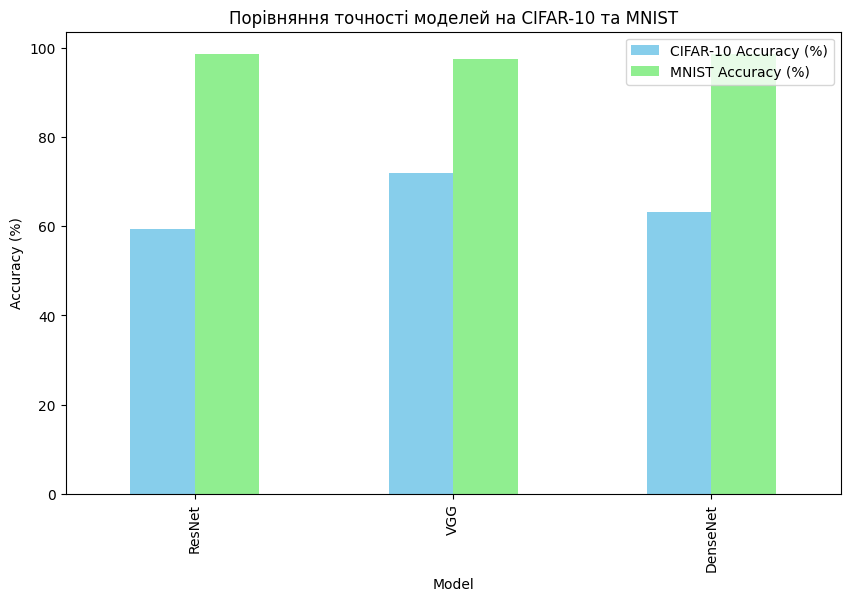

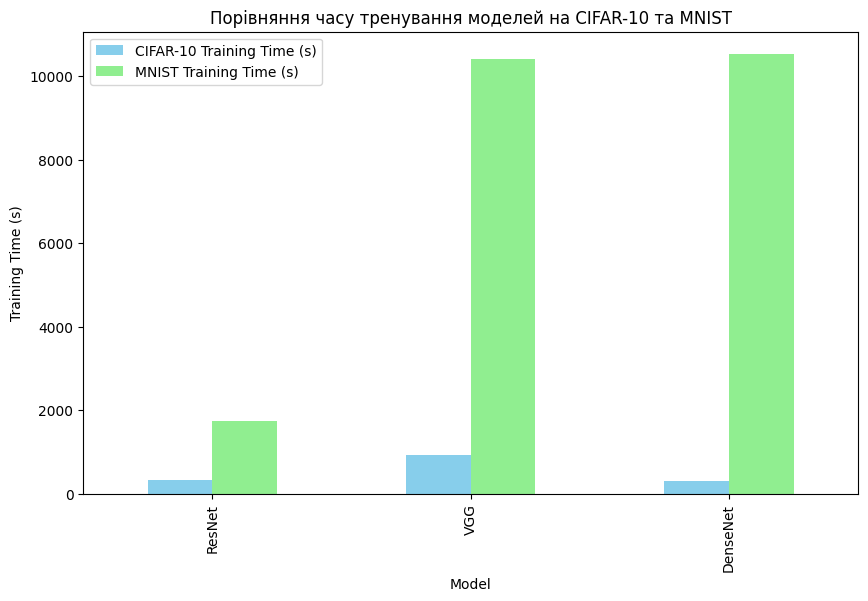

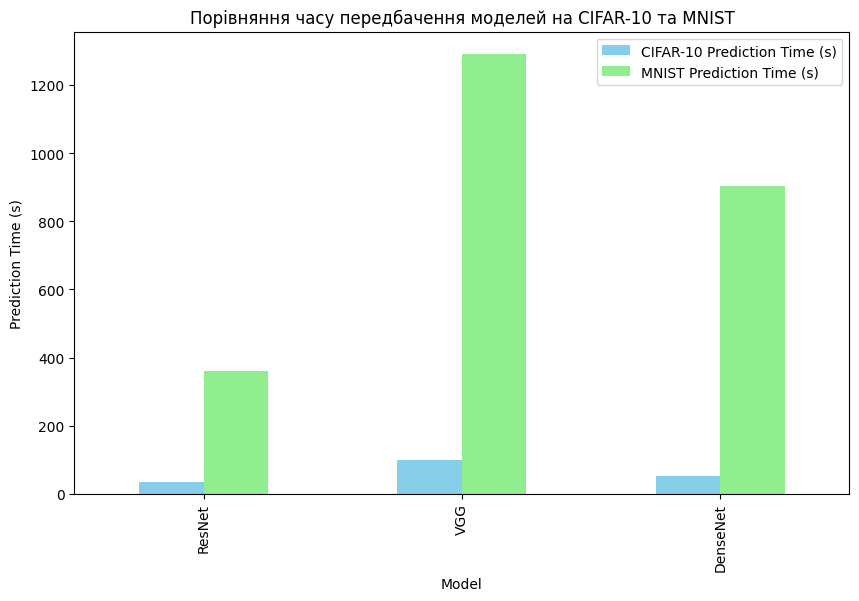

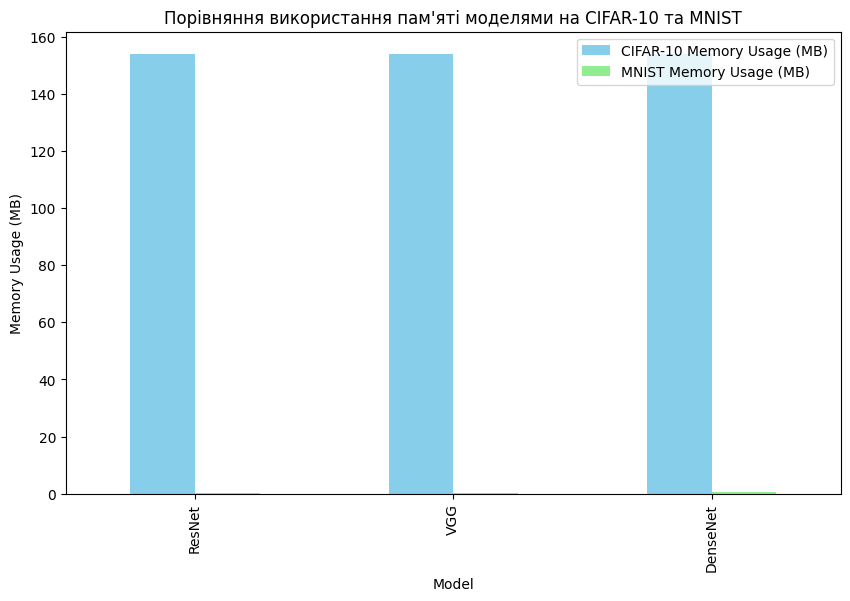

In [13]:
# Збір даних
results = {
    "Model": ["ResNet", "VGG", "DenseNet"],
    "CIFAR-10 Accuracy (%)": [resnet_accuracy_cifar10, vgg_accuracy_cifar10, densenet_accuracy_cifar10],
    "CIFAR-10 Training Time (s)": [resnet_training_time_cifar10, vgg_training_time_cifar10, densenet_training_time_cifar10],
    "CIFAR-10 Prediction Time (s)": [resnet_prediction_time_cifar10, vgg_prediction_time_cifar10, densenet_prediction_time_cifar10],
    "CIFAR-10 Memory Usage (MB)": [resnet_memory_cifar10, vgg_memory_cifar10, densenet_memory_cifar10],
    "MNIST Accuracy (%)": [resnet_accuracy_mnist, vgg_accuracy_mnist, densenet_accuracy_mnist],
    "MNIST Training Time (s)": [resnet_training_time_mnist, vgg_training_time_mnist, densenet_training_time_mnist],
    "MNIST Prediction Time (s)": [resnet_prediction_time_mnist, vgg_prediction_time_mnist, densenet_prediction_time_mnist],
    "MNIST Memory Usage (MB)": [resnet_memory_mnist, vgg_memory_mnist, densenet_memory_mnist]
}

df = pd.DataFrame(results)
print(df)

# Побудова діаграми для точності на CIFAR-10 та MNIST
df.set_index("Model")[["CIFAR-10 Accuracy (%)", "MNIST Accuracy (%)"]].plot(kind="bar", figsize=(10, 6), color=["skyblue", "lightgreen"])
plt.ylabel("Accuracy (%)")
plt.title("Порівняння точності моделей на CIFAR-10 та MNIST")
plt.show()

# Побудова діаграми для часу тренування на CIFAR-10 та MNIST
df.set_index("Model")[["CIFAR-10 Training Time (s)", "MNIST Training Time (s)"]].plot(kind="bar", figsize=(10, 6), color=["skyblue", "lightgreen"])
plt.ylabel("Training Time (s)")
plt.title("Порівняння часу тренування моделей на CIFAR-10 та MNIST")
plt.show()

# Побудова діаграми для часу передбачення на CIFAR-10 та MNIST
df.set_index("Model")[["CIFAR-10 Prediction Time (s)", "MNIST Prediction Time (s)"]].plot(kind="bar", figsize=(10, 6), color=["skyblue", "lightgreen"])
plt.ylabel("Prediction Time (s)")
plt.title("Порівняння часу передбачення моделей на CIFAR-10 та MNIST")
plt.show()

# Побудова діаграми для використання пам'яті на CIFAR-10 та MNIST
df.set_index("Model")[["CIFAR-10 Memory Usage (MB)", "MNIST Memory Usage (MB)"]].plot(kind="bar", figsize=(10, 6), color=["skyblue", "lightgreen"])
plt.ylabel("Memory Usage (MB)")
plt.title("Порівняння використання пам'яті моделями на CIFAR-10 та MNIST")
plt.show()
